In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
import json
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sn
from ray.tune import Analysis
from src.data import IFCNetNumpy
from src.models.models import MeshNet
from torch.utils.data import DataLoader, Subset, Dataset
import torch.nn.functional as F
import sklearn.metrics as metrics
import torch.nn as nn
from sklearn.preprocessing import label_binarize

In [3]:
data_root = Path("../data/processed/MeshNet/IFCNetCore")

with open("../IFCNetCore_Classes.json", "r") as f:
    class_names = json.load(f)

In [4]:
train_dataset = IFCNetNumpy(data_root, 2048, class_names, partition="train")
val_dataset = IFCNetNumpy(data_root, 2048, class_names, partition="train")
test_dataset = IFCNetNumpy(data_root, 2048, class_names, partition="test")

np.random.seed(42)
perm = np.random.permutation(range(len(train_dataset)))
train_len = int(0.7 * len(train_dataset))
train_dataset = Subset(train_dataset, sorted(perm[:train_len]))
val_dataset = Subset(val_dataset, sorted(perm[train_len:]))

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=8)

In [5]:
log_dir = Path("../logs/MeshNet/DEFAULT_2021-03-04_11-39-05//")
analysis = Analysis(log_dir, default_metric="val_balanced_accuracy_score", default_mode="max")
best_trial_dir = Path(analysis.get_best_logdir())

In [6]:
with (best_trial_dir/"params.json").open("r") as f:
    config = json.load(f)

model = MeshNet(config["num_kernel"], config["sigma"], config["aggregation_method"], output_channels=len(class_names))
model_state, _ = torch.load(best_trial_dir/"checkpoint_149"/"checkpoint")
model.load_state_dict(model_state)

<All keys matched successfully>

In [7]:
device = torch.device("cuda")
model.eval()
model.to(device)

MeshNet(
  (spatial_descriptor): SpatialDescriptor(
    (spatial_mlp): Sequential(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (structural_descriptor): StructuralDescriptor(
    (FRC): FaceRotateConvolution(
      (rotate_mlp): Sequential(
        (0): Conv1d(6, 32, kernel_size=(1,), stride=(1,))
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
        (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
      (fusion_mlp): Sequential(
        (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
        (1): BatchN

In [8]:
def calc_metrics(probabilities, labels):
    predictions = np.argmax(probabilities, axis=1)

    acc = metrics.accuracy_score(labels, predictions)
    balanced_acc = metrics.balanced_accuracy_score(labels, predictions)
    precision = metrics.precision_score(labels, predictions, average="weighted")
    recall = metrics.recall_score(labels, predictions, average="weighted")
    f1 = metrics.f1_score(labels, predictions, average="weighted")

    return {
        f"accuracy_score": acc,
        f"balanced_accuracy_score": balanced_acc,
        f"precision_score": precision,
        f"recall_score": recall,
        f"f1_score": f1
    }

def plot_confusion_matrix(confusion_matrix, display_labels, fname=None):
    labels = list(map(lambda x: x[3:], display_labels))
    df = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    plt.figure(figsize=(7, 5))
    sn.heatmap(df, cmap="Blues", annot=True, fmt="d", cbar=False)
    if fname:
        plt.savefig(fname, dpi=300, bbox_inches="tight")

def eval(model, loader, device, class_names, fname=None):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for data, labels in tqdm(loader):
            data, labels = data.to(device), labels.to(device)

            outputs = model(data)

            probs = F.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().detach().numpy())
            all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    result = calc_metrics(all_probs, all_labels)
    predictions = np.argmax(all_probs, axis=1)
    confusion_matrix = metrics.confusion_matrix(all_labels, predictions)
    print(result)
    plot_confusion_matrix(confusion_matrix, class_names, fname=fname)
    return all_labels, all_probs

100%|██████████| 122/122 [00:15<00:00,  7.65it/s]


{'accuracy_score': 0.9716859716859717, 'balanced_accuracy_score': 0.9725619003357131, 'precision_score': 0.9725722687957975, 'recall_score': 0.9716859716859717, 'f1_score': 0.9716728377717919}


(array([ 0,  0,  0, ..., 19, 19, 19]),
 array([[9.98260200e-01, 5.05242213e-07, 2.97011047e-06, ...,
         1.27857845e-07, 5.67275711e-05, 1.28046675e-08],
        [9.99999762e-01, 2.19891536e-10, 1.18724963e-09, ...,
         1.06187472e-14, 1.95634810e-11, 1.32440188e-13],
        [9.99786198e-01, 2.52962527e-05, 3.54756764e-07, ...,
         3.74512144e-10, 3.72977773e-08, 2.08519805e-06],
        ...,
        [5.16012388e-09, 2.06241051e-08, 1.64055347e-08, ...,
         3.59883076e-13, 1.94031938e-14, 9.99987364e-01],
        [2.11244696e-07, 3.19490425e-08, 1.55049112e-10, ...,
         1.18602895e-13, 9.47444705e-13, 9.99779880e-01],
        [2.15251039e-05, 2.02371684e-05, 5.27925067e-06, ...,
         1.88902867e-08, 1.18984449e-08, 9.96983707e-01]], dtype=float32))

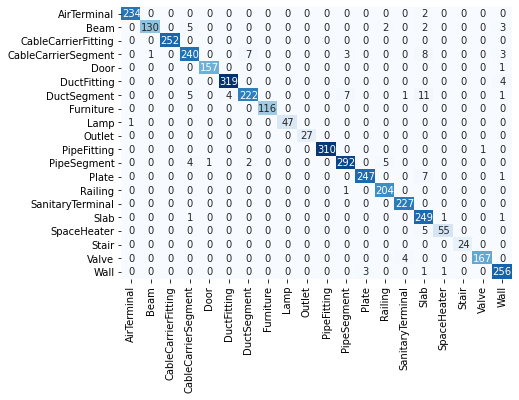

In [9]:
eval(model, train_loader, device, class_names)

100%|██████████| 53/53 [00:07<00:00,  7.34it/s]


{'accuracy_score': 0.9645858343337335, 'balanced_accuracy_score': 0.9678071553218313, 'precision_score': 0.9672461811432475, 'recall_score': 0.9645858343337335, 'f1_score': 0.9649173899108088}


(array([ 0,  0,  0, ..., 19, 19, 19]),
 array([[9.9999630e-01, 6.2497518e-09, 5.9212947e-11, ..., 3.1562846e-14,
         1.7631789e-10, 1.3419630e-09],
        [9.9950325e-01, 2.5740871e-07, 6.3922734e-08, ..., 3.7976037e-12,
         1.4774506e-09, 2.1938724e-06],
        [9.9959975e-01, 2.4480231e-08, 8.1963753e-06, ..., 1.8578368e-09,
         8.4914797e-07, 1.5050272e-09],
        ...,
        [5.1150506e-05, 1.2989516e-06, 4.8557212e-07, ..., 2.7144304e-11,
         1.4602429e-10, 9.9936992e-01],
        [7.9059381e-09, 5.6342238e-09, 5.0904871e-12, ..., 2.5389000e-16,
         8.1001263e-16, 9.9999928e-01],
        [1.6793268e-10, 3.1892424e-09, 2.5175371e-14, ..., 1.7630074e-17,
         2.5452663e-17, 9.9939156e-01]], dtype=float32))

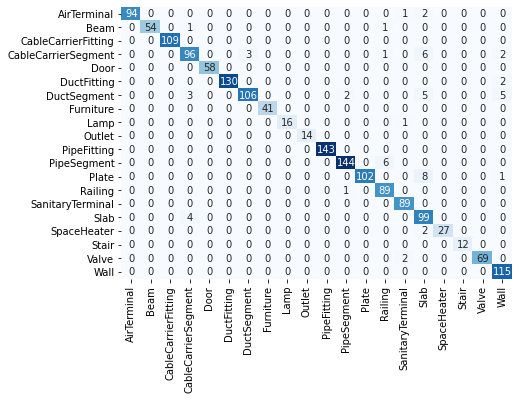

In [10]:
eval(model, val_loader, device, class_names)

100%|██████████| 75/75 [00:10<00:00,  7.41it/s]


{'accuracy_score': 0.8575031525851198, 'balanced_accuracy_score': 0.833171960048728, 'precision_score': 0.8644754581859599, 'recall_score': 0.8575031525851198, 'f1_score': 0.8572355220453319}


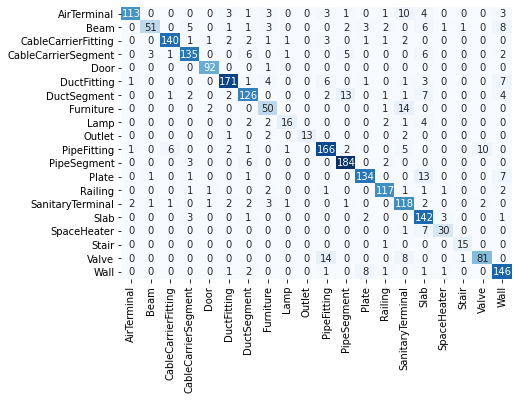

In [11]:
test_labels, test_probs = eval(model, test_loader, device,
                               class_names, fname="../reports/figures/meshnet_confusion.png")

In [12]:
np.savez("MeshNetProbs.npz", labels=test_labels, probs=test_probs)

In [13]:
test_predictions = np.argmax(test_probs, axis=1)
wrong_predictions = np.where(test_labels != test_predictions)[0]

In [14]:
wrong_pred_dir = Path("../data/external/MeshNet/wrong_classes/IFCNetCore")
raw_data_dict = {path.stem: path for path in Path("../data/raw/IFCNetCore").glob("**/test/*.obj")}
wrong_pred_dir.mkdir(parents=True, exist_ok=True)
for i in wrong_predictions:
    label_str = class_names[test_labels[i]]
    prediction_str = class_names[test_predictions[i]]
    print(f"{test_dataset.files[i].stem}, Label: {label_str}, Prediction: {prediction_str}")
    target_dir = wrong_pred_dir / label_str
    target_dir.mkdir(exist_ok=True)
    filename = test_dataset.files[i]
    shutil.copy(str(raw_data_dict[filename.stem]), str(target_dir / f"{filename.stem}_{prediction_str}.obj"))

074813d22a894bd299966b7fb2163749, Label: IfcAirTerminal, Prediction: IfcSlab
0b236e93969c43cba4a461e75aed680b, Label: IfcAirTerminal, Prediction: IfcWall
11cabe633ca745858610da5ba74dfaaf, Label: IfcAirTerminal, Prediction: IfcPipeFitting
1b198f2f3afd4ba680c37c41f55c84f7, Label: IfcAirTerminal, Prediction: IfcFurniture
1cffdb54dddd4b12aa859576298bb1e7, Label: IfcAirTerminal, Prediction: IfcFurniture
2035e2216c654ae0b23e62c56eaeb484, Label: IfcAirTerminal, Prediction: IfcSanitaryTerminal
334a4570ea2c44748251140812d50117, Label: IfcAirTerminal, Prediction: IfcSanitaryTerminal
39dcfc4c0b2d43b688646ba08cdb08e7, Label: IfcAirTerminal, Prediction: IfcSlab
59764e0479414af0a18096316ddd5681, Label: IfcAirTerminal, Prediction: IfcSlab
5bfd5d508e084fa6a436046276beb8df, Label: IfcAirTerminal, Prediction: IfcSlab
5d22f50391834b1dbce044ebf8a5eb04, Label: IfcAirTerminal, Prediction: IfcSanitaryTerminal
7abfdf8a14054b8faed65bd520001e2d, Label: IfcAirTerminal, Prediction: IfcDuctFitting
7ac5c781e86644d1